In [1]:
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
# Load and show data
df = pd.read_csv('AirlineTweets.csv')
df = df[['airline_sentiment', 'text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

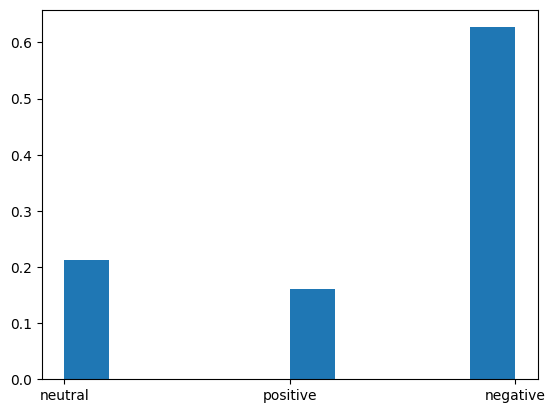

In [4]:
df['airline_sentiment'].hist(grid = False, weights = np.ones_like(df['airline_sentiment']) / len(df['airline_sentiment']))

**NOTE: Classes are imbalanced**

In [5]:
# Create integer labels
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
df['label'] = df['airline_sentiment'].map(label_map)
df.head()

,airline_sentiment,text,label
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


Create a Hugging Face Dataset instance and split it in *train*, *eval* and *test* (80, 10, 10).

In [6]:
from datasets import Dataset

In [7]:
raw_dataset = Dataset.from_pandas(df[['text', 'label']])

In [8]:
split_dataset = raw_dataset.train_test_split(test_size = 0.3, seed = 2023)

In [10]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4392
    })
})

Make sure that *train_test_split()* keeps original class frequencies

In [9]:
# https://stackoverflow.com/questions/483666/reverse-invert-a-dictionary-mapping
def inverse_mapping(f):
    return f.__class__(map(reversed, f.items()))

<Axes: >

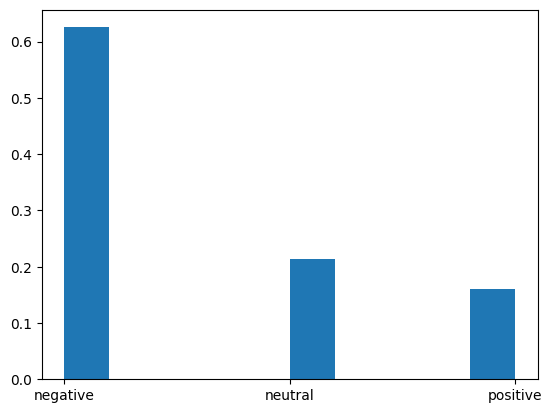

In [11]:
train_df = split_dataset['train'].to_pandas()
train_df['sentiment'] = train_df['label'].map(inverse_mapping(label_map))
train_df['sentiment'].hist(grid = False, weights = np.ones_like(train_df['sentiment']) / len(train_df['sentiment']))

<Axes: >

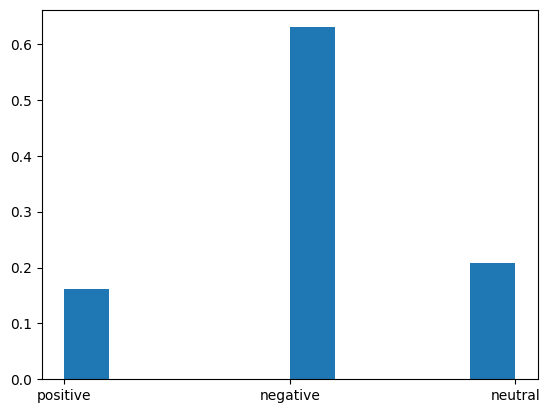

In [12]:
test_df = split_dataset['test'].to_pandas()
test_df['sentiment'] = test_df['label'].map(inverse_mapping(label_map))
test_df['sentiment'].hist(grid = False, weights = np.ones_like(test_df['sentiment']) / len(test_df['sentiment']))

Pre-process steps

**NOTE:**

Cased DistilBERT has been chosen for a faster training and it has been preferred to the uncased version because the use of upcase could have some intrinsic meaning in the language of social networks.

In [13]:
model_cp = 'distilbert-base-cased'

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_cp)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [15]:
def tokenize_func(batch):
  return tokenizer(batch['text'], truncation = True)

In [16]:
# Tokenize train, eval and test
tokenized_dataset = split_dataset.map(tokenize_func, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

Load model

In [17]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(model_cp, num_labels = 3)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
!pip install torchinfo

In [20]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

Fine-Tune for at most 3 epochs (it rapidly overfits)

In [21]:
training_args = TrainingArguments(
    output_dir = 'distilbert_training',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
)

In [22]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis = -1)
  accuracy = accuracy_score(labels, predictions)
  # average = 'macro' to adapt f1 to multiclass classification
  f1 = f1_score(labels, predictions, average = 'macro')
  return {'accuracy': accuracy, 'f1': f1}

In [23]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [24]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.545500,0.469256,0.828324,0.766846
2,0.348100,0.490107,0.830373,0.774400
3,0.234500,0.644401,0.830146,0.780821


TrainOutput(global_step=1923, training_loss=0.3260205725611837, metrics={'train_runtime': 198.1435, 'train_samples_per_second': 155.16, 'train_steps_per_second': 9.705, 'total_flos': 385172388897408.0, 'train_loss': 0.3260205725611837, 'epoch': 3.0})

Training loss large decrease + validation loss large increase at 3rd epoch -> Overfitting?

Select the model at 2nd epoch

In [25]:
from transformers import pipeline

In [27]:
# take the model at 2nd epoch
classifier = pipeline('text-classification',
                      model = '/content/distilbert_training/checkpoint-1282',
                      device = 0)

In [29]:
test_predictions = classifier(split_dataset['test']['text'])

In [30]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_predictions = [get_label(d) for d in test_predictions]

In [31]:
print('Accuracy: ', accuracy_score(split_dataset['test']['label'], test_predictions))
print('f1: ', f1_score(split_dataset['test']['label'], test_predictions, average = 'macro'))

Accuracy:  0.8303734061930783
f1:  0.7744001892835467


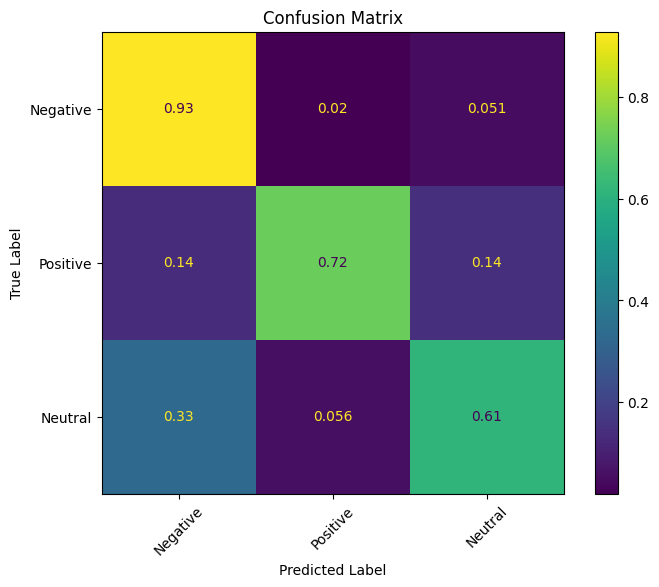

In [32]:
cm = confusion_matrix(split_dataset['test']['label'], test_predictions, normalize = 'true')
disp = ConfusionMatrixDisplay(cm)

# PLOT
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Set new class labels for both x-axis and y-axis
new_class_names = ['Negative', 'Positive', 'Neutral']
ax.set_xticklabels(new_class_names, rotation=45)  # Set new class names for x-axis
ax.set_yticklabels(new_class_names)  # Set new class names for y-axis

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

Let's try improving per-class performances by balancing the dataset

In [33]:
nr_classes = len(set(train_df['label']))
total_samples = len(train_df)
class_0_samples = len(train_df[train_df['label'] == 0])
class_1_samples = len(train_df[train_df['label'] == 1])
class_2_samples = len(train_df[train_df['label'] == 2])
weight_0 = total_samples / (nr_classes * class_0_samples)
weight_1 = total_samples / (nr_classes * class_1_samples)
weight_2 = total_samples / (nr_classes * class_2_samples)
balanced_class_weights = [weight_0, weight_1, weight_2]

In [34]:
balanced_class_weights

[0.5328341912338169, 2.0677966101694913, 1.5633867276887872]

In [35]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(balanced_class_weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [36]:
bal_training_args = TrainingArguments(
    output_dir = 'distilbert_balanced_training',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
)

In [37]:
bal_trainer = CustomTrainer(
    model,
    bal_training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [38]:
bal_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.218500,0.997289,0.820811,0.776764
2,0.124600,1.318811,0.824454,0.775203
3,0.101000,1.308827,0.828324,0.778033


TrainOutput(global_step=1923, training_loss=0.13311226022038927, metrics={'train_runtime': 195.7907, 'train_samples_per_second': 157.025, 'train_steps_per_second': 9.822, 'total_flos': 385172388897408.0, 'train_loss': 0.13311226022038927, 'epoch': 3.0})

Select the model at 1st epoch

In [39]:
bal_classifier = pipeline('text-classification',
                      model = '/content/distilbert_balanced_training/checkpoint-641',
                      device = 0)

In [40]:
bal_test_predictions = bal_classifier(split_dataset['test']['text'])

In [41]:
def get_label(d):
  return int(d['label'].split('_')[1])

bal_test_predictions = [get_label(d) for d in bal_test_predictions]

In [42]:
print('Accuracy: ', accuracy_score(split_dataset['test']['label'], bal_test_predictions))
print('f1: ', f1_score(split_dataset['test']['label'], bal_test_predictions, average = 'macro'))

Accuracy:  0.8208105646630237
f1:  0.7767644052204794


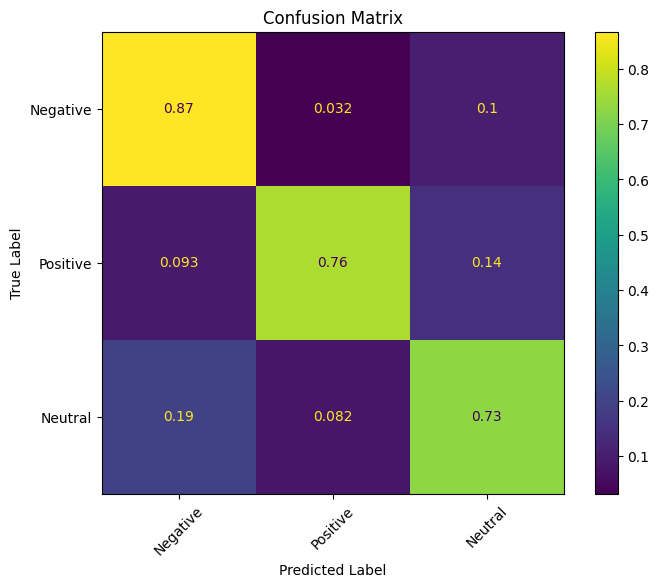

In [43]:
cm = confusion_matrix(split_dataset['test']['label'], bal_test_predictions, normalize = 'true')
disp = ConfusionMatrixDisplay(cm)

# PLOT
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Set new class labels for both x-axis and y-axis
new_class_names = ['Negative', 'Positive', 'Neutral']
ax.set_xticklabels(new_class_names, rotation=45)  # Set new class names for x-axis
ax.set_yticklabels(new_class_names)  # Set new class names for y-axis

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()